In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Render a colored point cloud

This tutorial shows how to:
- set up a renderer 
- render the point cloud 
- vary the rendering settings such as compositing and camera position

## Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        #!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
        print("no pytorch3d")

In [ ]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

### Load a point cloud and corresponding colors

Load and create a **Point Cloud** object. 

**Pointclouds** is a unique datastructure provided in PyTorch3D for working with batches of point clouds of different sizes. 

If running this notebook using **Google Colab**, run the following cell to fetch the pointcloud data and save it at the path `data/PittsburghBridge`:
If running locally, the data is already available at the correct path. 

In [ ]:
!mkdir -p /disk2/data/PittsburghBridge
!wget -P /disk2/data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")



In [ ]:
color_list = [[84, 107, 45], [178, 0, 0], [135, 206, 234]  ,[239, 196, 15]   ,[216, 112, 214]  ,[255, 127, 79]   ,[0, 127, 127]    ,[237, 58, 130]   ,[196, 237, 0]    ,[0, 0, 127]      ,[137, 53, 15]    ,[112, 127, 142]  ,[178, 127, 209]  ,[255, 216, 178]  ,[127, 127, 0]    ,[53, 68, 79]     ,[183, 75, 107],[70, 72, 107],[180, 123, 95],[137, 66, 70]]


In [428]:
# LOAD from .obj
_dir = '/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2'
#_dir = '/disk2/data/shape_dataset/data/shape/cube/1/cube_32_16_0_1_0'

_files = [_dir+"/"+f for f in os.listdir(_dir) if os.path.isfile(_dir+"/"+f)]
pcs = []
verts = []
rgbs = []
part_id = 0
for fname in _files:
    with open(fname) as infile:
        print(fname)
        _lines = infile.readlines()
        _part = []
        for _l in _lines:
            if _l.lower().startswith('v'):
                _part.append([float(a) for a in _l[2:].split()])
        verts.extend(_part)
        pcs.append(_part)
        rgbs.extend([color_list[part_id] for _ in range(len(_part))])
    part_id += 1

verts = torch.Tensor(verts).to(device)
rgbs = torch.Tensor(rgbs).to(device)



point_cloud = Pointclouds(points=[verts], features=[rgbs])

/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piece_12.obj
/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piece_0.obj
/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piece_15.obj
/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piece_17.obj
/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piece_7.obj
/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piece_11.obj
/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piece_14.obj
/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piece_10.obj
/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piece_13.obj
/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piece_5.obj
/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2/piec

[[-0.265537, -0.059322, 0.067797], [-0.268362, -0.056497, 0.067797]]
[[-0.265537, -0.059322, 0.090395], [-0.268362, -0.056497, 0.090395]]


In [432]:
import torch

def longest_plane_of_point_cloud(point_cloud):
    # Ensure the point cloud is a PyTorch tensor
    if not isinstance(point_cloud, torch.Tensor):
        point_cloud = torch.tensor(point_cloud, dtype=torch.float32)
    
    # Calculate the bounding box for each plane projection
    min_xy, _ = torch.min(point_cloud[:, :2], dim=0)
    max_xy, _ = torch.max(point_cloud[:, :2], dim=0)
    area_xy = (max_xy[0] - min_xy[0]) * (max_xy[1] - min_xy[1])
    
    min_xz, _ = torch.min(point_cloud[:, [0, 2]], dim=0)
    max_xz, _ = torch.max(point_cloud[:, [0, 2]], dim=0)
    area_xz = (max_xz[0] - min_xz[0]) * (max_xz[1] - min_xz[1])
    
    min_yz, _ = torch.min(point_cloud[:, 1:], dim=0)
    max_yz, _ = torch.max(point_cloud[:, 1:], dim=0)
    area_yz = (max_yz[0] - min_yz[0]) * (max_yz[1] - min_yz[1])
    
    # Compare the areas to find the largest plane
    areas = torch.tensor([area_xy, area_xz, area_yz])
    longest_plane_idx = torch.argmax(areas).item()
    
    # Plane names for convenience
    plane_names = ['XY', 'XZ', 'YZ']
    
    return plane_names[longest_plane_idx], areas

# Example usage
# Create a point cloud with random points
points = torch.rand((100, 3))  # 100 points with x, y, z coordinates
points = pcs[0]
# Find the longest plane of the point cloud
longest_plane, plane_areas = longest_plane_of_point_cloud(points)

print(f"The longest plane is: {longest_plane} with areas {plane_areas}")


The longest plane is: XY with areas tensor([0.5090, 0.0171, 0.0152])


In [423]:
max_num_part = 20

def _pad_data(data):
    """Pad data to shape [`self.max_num_part`, data.shape[1], ...]."""
    data = np.array(data)
    pad_shape = (max_num_part, ) + tuple(data.shape[1:])
    pad_data = np.zeros(pad_shape, dtype=np.float32)
    pad_data[:data.shape[0]] = data
    return pad_data


In [424]:
from scipy.spatial.transform import Rotation as R

pc1 = verts[:5].cpu().numpy()
pc2 = verts[5:10].cpu().numpy()


cur_pts = []

for pc in [pc1, pc2]:
    print("\n",'pc',pc)
    rot_mat = R.random().as_matrix()
    print('rot_mat',rot_mat)
    print('pc.T',pc.T)
    print('rot_mat @ pc.T', rot_mat @ pc.T)
    pc = (rot_mat @ pc.T).T
    print('pc',pc)
    #print(pc.shape)
    
    quat_gt = R.from_matrix(rot_mat.T).as_quat()
    print('quat_gt',quat_gt)
    # we use scalar-first quaternion
    quat_gt = quat_gt[[3, 0, 1, 2]]
    print('quat_gt',quat_gt)
    cur_pts.append(pc)


print('cur_pts',cur_pts)
cur_pts = _pad_data(np.stack(cur_pts, axis=0))  # [P, N, 3]
print('cur_pts',cur_pts.shape)
#scale = np.max(np.abs(cur_pts), axis=(1,2), keepdims=True)
print('scale',scale)
#scale[scale == 0] = 1
#cur_pts = cur_pts / scale




 pc [[-0.265537 -0.059322  0.067797]
 [-0.268362 -0.056497  0.067797]
 [-0.265537 -0.059322  0.073446]
 [-0.268362 -0.056497  0.073446]
 [-0.268362 -0.050847  0.067797]]
rot_mat [[ 0.69441025 -0.23885461 -0.67878043]
 [-0.58805903 -0.73201165 -0.34401384]
 [-0.41470589  0.6380497  -0.648777  ]]
pc.T [[-0.265537 -0.268362 -0.265537 -0.268362 -0.268362]
 [-0.059322 -0.056497 -0.059322 -0.056497 -0.050847]
 [ 0.067797  0.067797  0.073446  0.073446  0.067797]]
rot_mat @ pc.T [[-0.21624155 -0.21887802 -0.22007598 -0.22271245 -0.22022755]
 [ 0.17625272  0.17584605  0.17430938  0.17390271  0.17171018]
 [ 0.02828424  0.03125827  0.0246193   0.02759333  0.03486325]]
pc [[-0.21624155  0.17625272  0.02828424]
 [-0.21887802  0.17584605  0.03125827]
 [-0.22007598  0.17430938  0.0246193 ]
 [-0.22271245  0.17390271  0.02759333]
 [-0.22022755  0.17171018  0.03486325]]
quat_gt [ 0.87681225 -0.23577272 -0.31177893 -0.28000964]
quat_gt [-0.28000964  0.87681225 -0.23577272 -0.31177893]

 pc [[-0.268362 -

In [480]:
import scipy
scipy.spatial.transform.Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()

array([[ 2.22044605e-16, -1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  2.22044605e-16,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [649]:
# LOAD from .npz
# Set paths

from scipy.spatial.transform import Rotation as R
DATA_DIR = "/disk2/data/shape_dataset/data/test_data/"
#obj_filename = os.path.join(DATA_DIR, "PittsburghBridge/pointcloud.npz")
obj_filename = os.path.join(DATA_DIR, "100_rt.npz")
# Load point cloud
pointcloud = np.load(obj_filename)
#print(pointcloud)

color_list = [[84, 107, 45], [178, 0, 0], [135, 206, 234]  ,[239, 196, 15]   ,[216, 112, 214]  ,[255, 127, 79]   ,[0, 127, 127]    ,[237, 58, 130]   ,[196, 237, 0]    ,[0, 0, 127]      ,[137, 53, 15]    ,[112, 127, 142]  ,[178, 127, 209]  ,[255, 216, 178]  ,[127, 127, 0]    ,[53, 68, 79]     ,[183, 75, 107],[70, 72, 107],[180, 123, 95],[137, 66, 70]]

verts = []
rgbs = []
print(pointcloud['arr_0'].shape)
for part_id in range(pointcloud['arr_0'].shape[0]):
    _part = (pointcloud['arr_0'][part_id])
    _part = np.array([list(a) for a in _part])

    #rot_mat = scipy.spatial.transform.Rotation.random().as_matrix()
    rot_mat = scipy.spatial.transform.Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()
    _part = (rot_mat @ _part.T).T

    #for _p  in _part:
    #    _p[2] = 0
    verts.extend(_part)
    rgbs.extend([color_list[part_id] for _ in range(len(_part))])
#verts = torch.Tensor(pointcloud['verts']).to(device)
#verts = torch.Tensor(pointcloud['arr_0']).to(device)
verts = torch.Tensor(verts).to(device)
rgbs = torch.Tensor(rgbs).to(device)
point_cloud = Pointclouds(points=[verts], features=[rgbs])

(20, 1000, 3)


## Create a renderer

A renderer in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthographic/perspective). Here we initialize some of these components and use default values for the rest.

In this example we will first create a **renderer** which uses an **orthographic camera**, and applies **alpha compositing**. Then we learn how to vary different components using the modular API.  

[1] <a href="https://arxiv.org/abs/1912.08804">SynSin: End to end View Synthesis from a Single Image.</a> Olivia Wiles, Georgia Gkioxari, Richard Szeliski, Justin Johnson. CVPR 2020.

In [650]:
from pytorch3d.renderer.mesh.shader import HardPhongShader
# Initialize a camera.
#R, T = look_at_view_transform(20, 10, 0)
R, T = look_at_view_transform(dist=50, elev=50,azim=10)

#An azimuth is the horizontal angle from a cardinal direction, most commonly north

print(R)
print(T)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=50)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.001,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer
    ,compositor=AlphaCompositor()
    #,shader=HardPhongShader(device=device, cameras=cameras)
)

tensor([[[-0.9848, -0.1330, -0.1116],
         [ 0.0000,  0.6428, -0.7660],
         [ 0.1736, -0.7544, -0.6330]]])
tensor([[-0.0000e+00, -1.9073e-06,  5.0000e+01]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.71825].


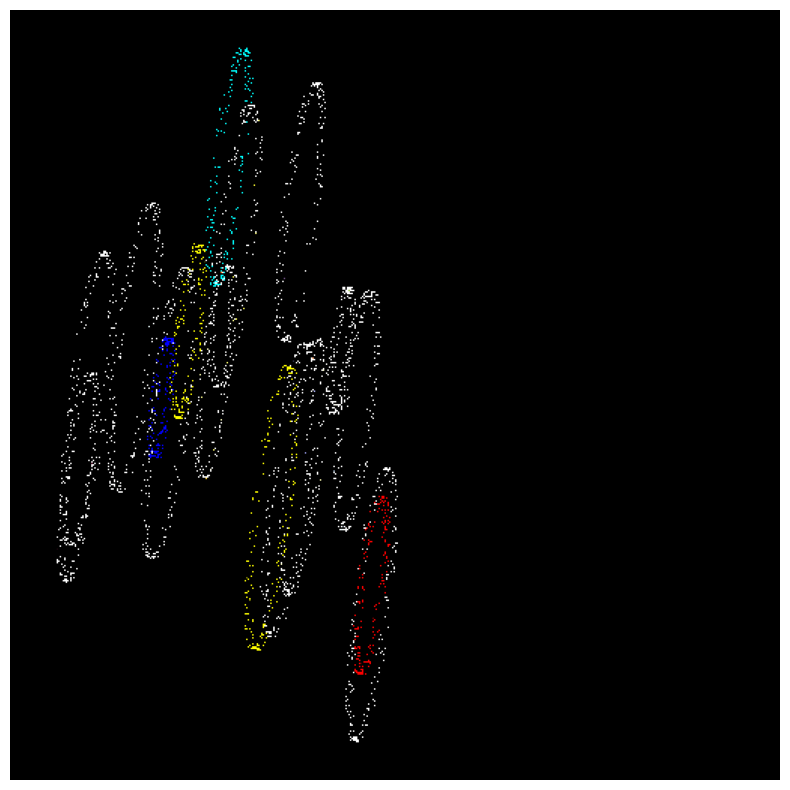

In [651]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [3]:
import jahn_src.myutil
import importlib
importlib.reload(jahn_src.myutil)
from jahn_src.myutil import *
import os

_dir = '/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2'
#_dir = '/disk2/data/shape_dataset/data/shape/cube/1/cube_32_16_0_1_0'
files = [_dir+"/"+f for f in os.listdir(_dir) if os.path.isfile(_dir+"/"+f)]

#rot_mat = scipy.spatial.transform.Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()


pcs = []
for fname in files:    
    
    with open(fname) as infile:     
        _pcs = []
        for line in infile:
            if line.lower().startswith('v'):
                _arr = line[2:].split()
                _arr = np.array([float(a) for a in _arr])                    
                _pcs.append(_arr)
        _pcs = np.array(_pcs)
    pcs.append(_pcs)

_pcs = pcs[1]

points = get_plane(_pcs)
normal_vector = calculate_normal_vector(points[0],points[1],points[2])
print(normal_vector/ np.linalg.norm(normal_vector))

normal_vector = calculate_normal_vector_open3d(_pcs)
print(normal_vector/ np.linalg.norm(normal_vector))

print(np.min(_pcs, axis=0))
print(np.max(_pcs, axis=0))
rotated_points, translation_vector, quat_gt = rotate_and_translate_to_xy_plane(_pcs, normal_vector)

print(np.min(rotated_points, axis=0))
print(np.max(rotated_points, axis=0))
print(translation_vector)
print(quat_gt)
print(np.mean(_pcs, axis=0))


[ 0.70723194  0.7069816  -0.        ]
[ 9.00885161e-18 -1.53493170e-19  1.00000000e+00]
[-0.432203 -0.155367 -0.20339 ]
[-0.087571  0.155367 -0.180791]
[0.54033698 0.66473106 0.14391133]
[0.88496898 0.68733006 0.45464533]
[0.97253998 0.86812106 0.29927833]
[ 7.07106781e-01 -7.07106781e-01  0.00000000e+00  6.37022007e-18]
[-2.53689231e-01 -3.83192648e-19 -1.92090400e-01]


In [634]:
_dir = '/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_3_0_2'
_dir = '/disk2/data/shape_dataset/data/shape/ellipsoid/0/ellipsoid_512_128_64_64_0_1_0'
#_dir = '/disk2/data/shape_dataset/data/shape/cube/1/cube_32_16_0_1_0'
files = [_dir+"/"+f for f in os.listdir(_dir) if os.path.isfile(_dir+"/"+f)]

#rot_mat = scipy.spatial.transform.Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()

f_2_last = []
with open('ellipsoid_.obj', 'w') as outfile:

    f_2_last.append(0)
    for fname in files:
        
        _c = 0
        with open(fname) as infile:
            _pcs = []
            for line in infile:
                if line.lower().startswith('v'):
                    _c += 1
                    _arr = line[2:].split()
                    _arr = np.array([float(a) for a in _arr])                    
                    _pcs.append(_arr)

            _pcs = np.array(_pcs)
            normal_vector = calculate_normal_vector_open3d(_pcs)
            _pcs = rotate_and_translate_to_xy_plane(_pcs, normal_vector)
            for _arr in _pcs:
                outfile.write(f'v {_arr[0]} {_arr[1]} {_arr[2]}\n')
                  
        

        f_2_last.append(_c)
    print(f_2_last)
    _delta = 0
    for fi, fname in enumerate(files):
        _delta += f_2_last[fi]
        with open(fname) as infile:
            for line in infile:
                if line.lower().startswith('f'):
                    _arr = line[2:].split()
                    outfile.write(f'f {int(_arr[0])+_delta} {int(_arr[1])+_delta} {int(_arr[2])+_delta}\n')

[0, 3500, 1640, 2600, 1160, 3800, 3680, 2980, 3760, 3280, 3580, 2320, 3700, 2060, 3820, 2780, 3400, 3820, 3140]


In [ ]:
mesh = pytorch3d.io.load_objs_as_meshes(['file.obj'])
mesh

In [ ]:
mesh.extend(num_views)

In [187]:
import imageio
num_views = 30
R, T = pytorch3d.renderer.look_at_view_transform(
    dist=3,
    elev=0,
    azim=np.linspace(-180, 180, num_views, endpoint=False),
)

many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)
light = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)
_images = renderer(point_cloud.extend(num_views), cameras=many_cameras, lights = light)[:,:,:,0:3]
_images = np.array(_images.cpu()) * 255
_images = _images.astype(np.uint8)
imageio.mimsave("360_degree_cow.gif", list(_images), fps=10)


We will now modify the **renderer** to use **alpha compositing** with a set background color. 

In [ ]:
renderer = PointsRenderer(
    rasterizer=rasterizer,
    # Pass in background_color to the alpha compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
    compositor=AlphaCompositor(background_color=(0, 0, 1))
)
images = renderer(point_cloud)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In this example we will first create a **renderer** which uses an **orthographic camera**, and applies **weighted compositing**. 

In [ ]:
# Initialize a camera.
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an weighted compositor (3D points are
# weighted according to their distance to a pixel and accumulated using a weighted sum)
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=NormWeightedCompositor()
)


In [ ]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

We will now modify the **renderer** to use **weighted compositing** with a set background color. 

In [ ]:
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    # Pass in background_color to the norm weighted compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case red
    compositor=NormWeightedCompositor(background_color=(1,0,0))
)
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

## Using the pulsar backend

Switching to the pulsar backend is easy! The pulsar backend has a compositor built-in, so the `compositor` argument is not required when creating it (a warning will be displayed if you provide it nevertheless). It pre-allocates memory on the rendering device, that's why it needs the `n_channels` at construction time.

All parameters for the renderer forward function are batch-wise except the background color (in this example, `gamma`) and you have to provide as many values as you have examples in your batch. The background color is optional and by default set to all zeros. You can find a detailed explanation of how gamma influences the rendering function here in the paper [Fast Differentiable Raycasting for Neural Rendering using
Sphere-based Representations](https://arxiv.org/pdf/2004.07484.pdf).

You can also use the `native` backend for the pulsar backend which already provides access to point opacity. The native backend can be imported from `pytorch3d.renderer.points.pulsar`; you can find examples for this in the folder `docs/examples`.

In [ ]:
renderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=4
).to(device)

images = renderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([0.0, 1.0, 0.0, 1.0], dtype=torch.float32, device=device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

### View pointclouds in Plotly figures

Here we use the PyTorch3D function `plot_scene` to render the pointcloud in a Plotly figure. `plot_scene` returns a plotly figure with trace and subplots defined by the input.

In [ ]:
plot_scene({
    "Pointcloud": {
        "person": point_cloud
    }
})

We will now render a batch of pointclouds. The first pointcloud is the same as above, and the second is all-black and offset by 2 in all dimensions so we can see them on the same plot. 

In [ ]:
point_cloud_batch = Pointclouds(points=[verts, verts + 2], features=[rgb, torch.zeros_like(rgb)])
# render both in the same plot in different traces
fig = plot_scene({
    "Pointcloud": {
        "person": point_cloud_batch[0],
        "person2": point_cloud_batch[1]
    }
})
fig.show()

In [ ]:
# render both in the same plot in one trace
fig = plot_scene({
    "Pointcloud": {
        "2 people": point_cloud_batch
    }
})
fig.show()

For batches, we can also use `plot_batch_individually` to avoid constructing the scene dictionary ourselves.

In [ ]:
# render both in 1 row in different subplots
fig2 = plot_batch_individually(point_cloud_batch, ncols=2)
fig2.show()

In [ ]:
# modify the plotly figure height and width
fig2.update_layout(height=500, width=500)
fig2.show()

We can also modify the axis arguments and axis backgrounds for either function, and title our plots in `plot_batch_individually`.

In [ ]:
fig3 = plot_batch_individually(
    point_cloud_batch, 
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    subplot_titles=["Pointcloud1", "Pointcloud2"], # this should have a title for each subplot, titles can be ""
    axis_args=AxisArgs(showgrid=True))
fig3.show()